In [1]:
import os
import umap
import sys
import h5py
import torch
import random
import sklearn
import datetime 
import numpy as np
import pandas as pd
from torch import nn
from collections import Counter
from matplotlib import pyplot as plt 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from scipy.stats import pearsonr # Pearson cor

In [2]:
# Adding initial project root to path

path_to_module = '../'

# Add this path to sys.path
if path_to_module not in sys.path:
    sys.path.insert(0, path_to_module)

In [3]:
# custom 
import common.engines as engines 
import common.plotting as plotting 
import common.dataprocessing as dataprocessing


# Travail Pratique 6 : Introduction au benchmarking de réseaux de neurones artificiels sur des données transcriptomiques de cancers.

## Importation et visualisation des données avec UMAP

#### 1. Chargement les données en python dans un format matriciel et vectoriel

In [4]:
datasets = dataprocessing.load_datasets()

In [5]:
datasets.keys()

dict_keys(['TCGA', 'BRCA', 'TALL', 'LAML'])

In [94]:
datasetname = "LAML"
tpm_data = datasets[datasetname].data
genes = datasets[datasetname].genes
labels = datasets[datasetname].labels
samples = datasets[datasetname].samples

In [95]:
samples.shape

(300,)

#### 2. Visualisation avec UMAP

In [96]:
X_train, X_test, Y_train, Y_test = train_test_split(tpm_data.T, labels, test_size = 0.2)

In [97]:
mapper = umap.UMAP(verbose = 1,min_dist=0.5, n_neighbors =10, n_epochs = 1000).fit(X_train)

UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=10, verbose=1)
Sun Dec 17 13:29:40 2023 Construct fuzzy simplicial set
Sun Dec 17 13:29:41 2023 Finding Nearest Neighbors
Sun Dec 17 13:29:41 2023 Finished Nearest Neighbor Search
Sun Dec 17 13:29:41 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Sun Dec 17 13:29:44 2023 Finished embedding


In [98]:
X_tr_umap = mapper.transform(X_train)
X_tst_umap = mapper.transform(X_test)

Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs


In [99]:
def random_color_generator():
    r = random.randint(0, 255)/256
    g = random.randint(0, 255)/256
    b = random.randint(0, 255)/256
    return (r, g, b)

In [102]:
def plot_umap(X_train_umap, X_test_umap, Y_train, Y_test, labels, s= 8):
    fig, ax1 = plt.subplots(figsize=(12,7))
    ax1.grid(visible=True,linestyle="--")
    ax1.set_axisbelow(True)
    markers_ = np.concatenate([['o',"v","^","<",">","8","p","s","h","D","P","X"] for i in range(10)])
    colors_by_ctype = [random_color_generator() for  i in range(len(np.unique(labels)))]
    for (i,lbl) in enumerate(np.unique(labels)):
        #defin_ = tcga_abbrevs.loc[tcga_abbrevs["abbrv"] == lbl,"def"].values[0] 
        #count_ = counts_df.loc[counts_df["c_type"] == lbl,"count"].values[0]
        #tag = f"{defin_} ({count_})"
        #print(X_tr_tsne[labels ==lbl,0])
        ax1.scatter(X_train_umap[Y_train ==lbl,0], 
                X_train_umap[Y_train ==lbl,1], 
                s = s, color = colors_by_ctype[i], linewidth = 0.5, marker=markers_[i], label = lbl)
        ax1.scatter(X_test_umap[Y_test ==lbl,0], 
                X_test_umap[Y_test ==lbl,1], 
                s = s, edgecolors = colors_by_ctype[i], color ="white", linewidth = 0.5, marker=markers_[i])

    ax1.axis("equal")
    ax1.legend(bbox_to_anchor=(1,1),fontsize = 8, title="Type of cancer")
    ax1.set_xlabel("UMAP1")
    ax1.set_ylabel("UMAP2")
    #fig.tight_layout()
    plt.title(f"UMAP analysis of gene expression with the test points for {datasetname} data")
    plt.tight_layout()
    plt.savefig(f"figures/figUMAP_{datasetname}.png", format="png", dpi=500)

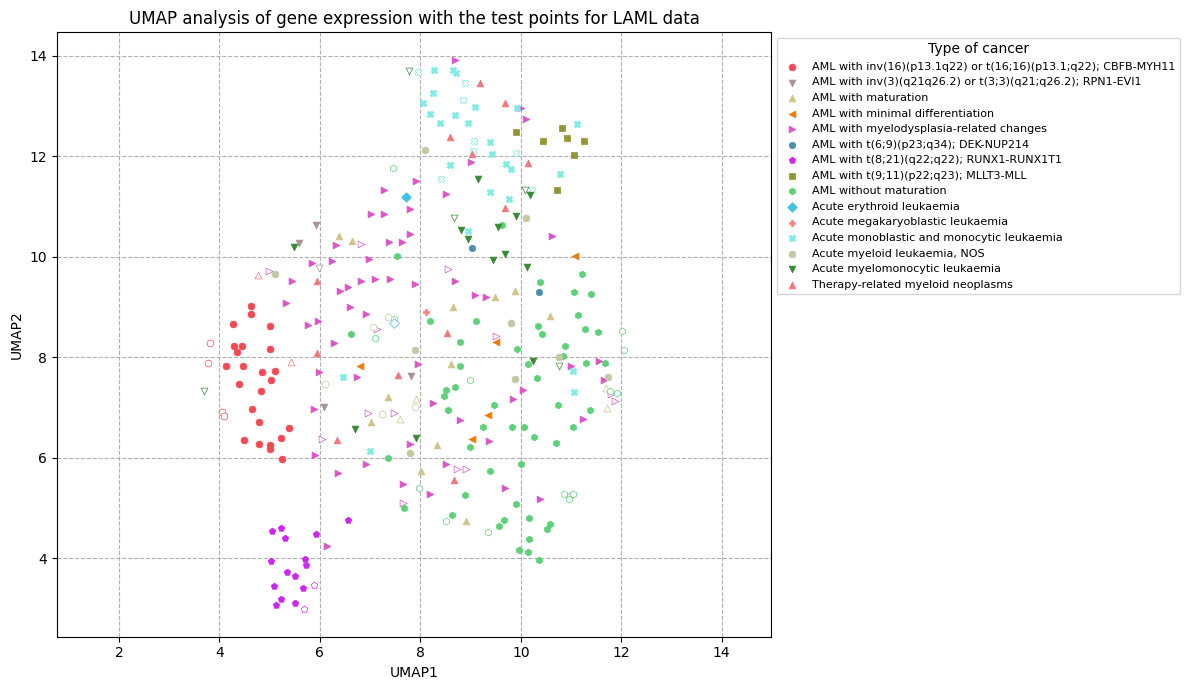

In [103]:
plot_umap(X_tr_umap, X_tst_umap, Y_train, Y_test, labels, s=24)

## II. Création d'un réseau de neurones artificiel pour un problème de régression avec un auto-encodeur. 

#### 1. Créez une fonction qui construit un modèle DNN selon la structure <code>encoder => bottleneck => decoder</code>

In [61]:
lblbin = LabelBinarizer()
Y = torch.Tensor(lblbin.fit_transform(labels))
X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(tpm_data.T), torch.Tensor(Y),test_size=0.2)
insize = X_train.shape[1] ## some model setting variables

In [62]:
AE, encoder  = engines.auto_encoder(insize, insize, 2)
encoder(X_train).shape

torch.Size([818, 2])

#### 2. Lancez un entrainement de 1000 epochs et enregistrez la performance du modèle par epoch sous la forme de l'erreur et la correlation de Pearson sur l'ensemble de test et de train

In [63]:
mm, trl, tstl, trc, tstc  = engines.train_auto_encoder(insize, 125, X_train, X_test, nepochs = 1000, lr = 5 * 1e-4)

Loss 0 Train - loss : 0.151 - acc : 0.003 Test acc : 0.003
Loss 10 Train - loss : 0.148 - acc : 0.022 Test acc : 0.021
Loss 20 Train - loss : 0.145 - acc : 0.041 Test acc : 0.04
Loss 30 Train - loss : 0.139 - acc : 0.069 Test acc : 0.068
Loss 40 Train - loss : 0.122 - acc : 0.123 Test acc : 0.12
Loss 50 Train - loss : 0.085 - acc : 0.24 Test acc : 0.235
Loss 60 Train - loss : 0.045 - acc : 0.453 Test acc : 0.443
Loss 70 Train - loss : 0.028 - acc : 0.628 Test acc : 0.613
Loss 80 Train - loss : 0.026 - acc : 0.655 Test acc : 0.64
Loss 90 Train - loss : 0.026 - acc : 0.656 Test acc : 0.641
Loss 100 Train - loss : 0.026 - acc : 0.661 Test acc : 0.646
Loss 110 Train - loss : 0.026 - acc : 0.664 Test acc : 0.649
Loss 120 Train - loss : 0.026 - acc : 0.665 Test acc : 0.65
Loss 130 Train - loss : 0.026 - acc : 0.666 Test acc : 0.651
Loss 140 Train - loss : 0.026 - acc : 0.666 Test acc : 0.651
Loss 150 Train - loss : 0.026 - acc : 0.666 Test acc : 0.651
Loss 160 Train - loss : 0.026 - acc : 0.

#### 3. Produisez la courbe d'apprentissage de l'entrainement de ce réseau, c'est à dire la courbe de l'erreur sur le test et le train et la corrélation de Pearson selon les epochs.

In [66]:
def plot_learning_curves(trl, tstl, trc, tstc, tpm_data, X_train, X_test):
    steps = np.arange(len(trl))
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(10, 8))
    axes[0].plot(steps, trl, label = "train")
    axes[0].plot(steps, tstl, label= "test")
    axes[1].plot(steps, trc * 100, label = "train")
    axes[1].plot(steps, tstc * 100, label= "test")
    axes[0].set_ylabel("Loss")
    axes[1].set_ylabel("Pearson Correlation")
    axes[1].set_ylim((0,100))
    axes[1].set_xlabel("Gradient step")
    axes[0].legend()
    axes[0].set_title(f"Learning curves of DNN on {datasetname} data\nN={tpm_data.shape[1]}, N(train)={X_train.shape[0]}, N(test)={X_test.shape[0]}")
    plt.savefig(f"figures/DNN_learning_curves.png", format="png", dpi=500)


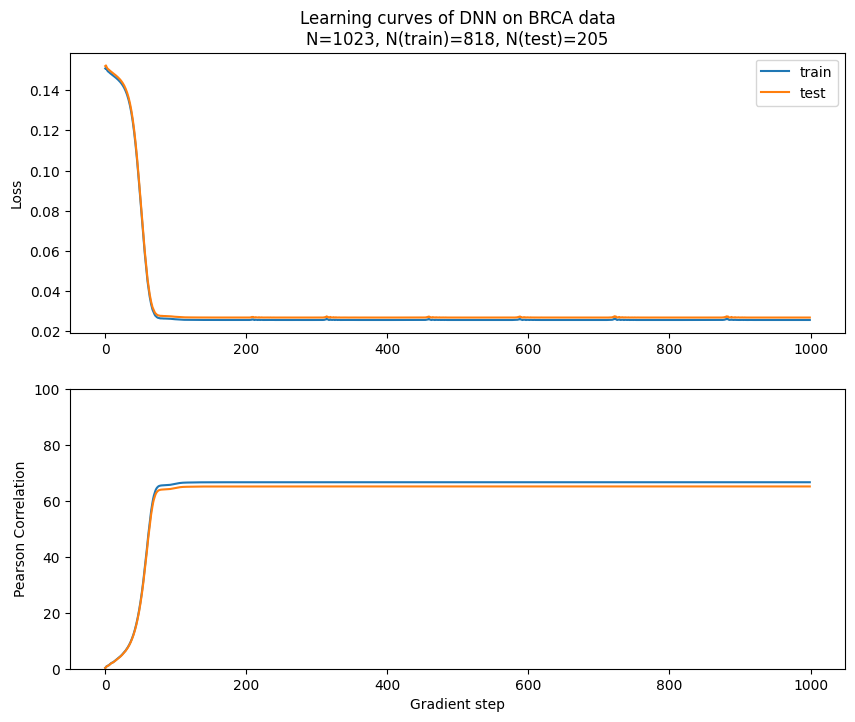

In [67]:
plot_learning_curves(trl, tstl, trc, tstc, tpm_data, X_train, X_test)

#### 4. Faites la visualisation de la corrélation sur les données de test prédites et vraies. Rapportez votre résultat sous la forme d'un histogramme 2D avec des hexagones, l'échelle de la densité doit être rapportées.

In [68]:
def plot_ae_performance(mm, X_test, modeltype = "AE", dataset = "TPM_DATA"):
    y_tst_out = mm(X_test)
    outs = y_tst_out.flatten().detach().numpy()
    trues = X_test.flatten().detach().numpy()
    corr =  pearsonr(outs,trues).statistic
    plt.figure(figsize = (9,7))
    plt.grid(visible =True, alpha = 0.5, linestyle = "--")
    lims = max([max(outs), max(trues)])
    plt.plot([0,lims],[0,lims], color = "blue", alpha =0.5, linestyle = "--")
    plt.hexbin(outs, trues, bins = "log")
    plt.xlabel("Predicted Expressions (normalised TPM)")
    plt.ylabel("True expressions")
    plt.colorbar(label='log10(N)')
    plt.axis("equal")
    plt.title(f"Auto-Encoder performance of reconstruction on test set with {datasetname} data.\nPearson Correlation: {round(corr,4)}")
    plt.savefig(f"figures/{modeltype}_{dataset}_reconstruction.png", format="png", dpi=500)

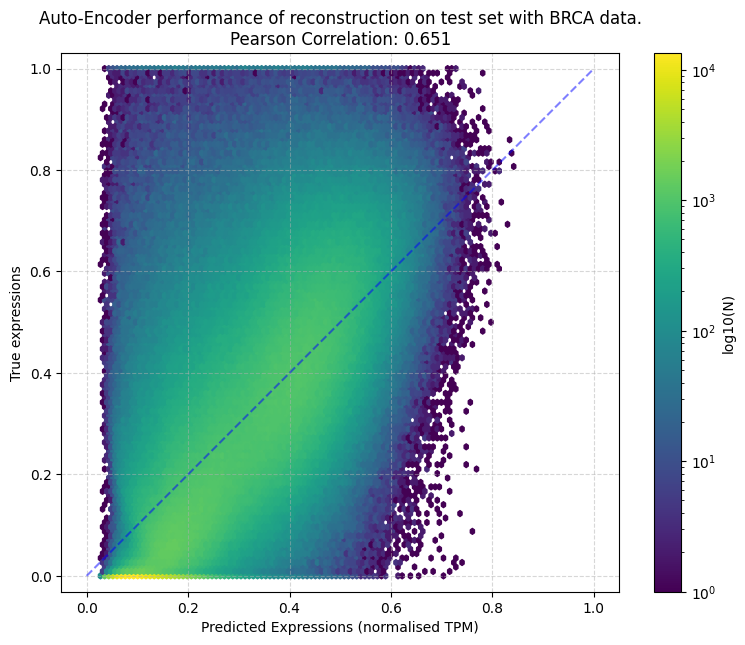

In [69]:
plot_ae_performance(mm, X_test, dataset = datasetname)

## III. Variational Auto-Encoders (VAE) pour un gain de performance de reconstruction dans les problèmes de régression.

In [70]:
lblbin = LabelBinarizer()
Y = torch.Tensor(lblbin.fit_transform(labels))
X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(tpm_data.T), torch.Tensor(Y),test_size=0.2)
insize = X_train.shape[1] ## some model setting variables

In [71]:
mm = engines.VariationalAutoencoder(insize, 2)

In [72]:
VAE, trl, tstl, trc, tstc = engines.train_variational_auto_encoder(insize, 125, X_train, X_test, nepochs = 1000, printstep = 10, wd = 1e-3, lr = 1e-3)

Loss 0 Train - loss : 0.24 - acc : 0.001 Test acc : 0.0
Loss 10 Train - loss : 0.224 - acc : 0.066 Test acc : 0.064
Loss 20 Train - loss : 0.097 - acc : 0.205 Test acc : 0.198
Loss 30 Train - loss : 0.058 - acc : 0.379 Test acc : 0.366
Loss 40 Train - loss : 0.03 - acc : 0.605 Test acc : 0.585
Loss 50 Train - loss : 0.027 - acc : 0.651 Test acc : 0.629
Loss 60 Train - loss : 0.026 - acc : 0.655 Test acc : 0.633
Loss 70 Train - loss : 0.026 - acc : 0.662 Test acc : 0.641
Loss 80 Train - loss : 0.026 - acc : 0.665 Test acc : 0.643
Loss 90 Train - loss : 0.026 - acc : 0.666 Test acc : 0.645
Loss 100 Train - loss : 0.026 - acc : 0.667 Test acc : 0.645
Loss 110 Train - loss : 0.026 - acc : 0.667 Test acc : 0.645
Loss 120 Train - loss : 0.026 - acc : 0.668 Test acc : 0.646
Loss 130 Train - loss : 0.026 - acc : 0.668 Test acc : 0.646
Loss 140 Train - loss : 0.025 - acc : 0.668 Test acc : 0.646
Loss 150 Train - loss : 0.025 - acc : 0.669 Test acc : 0.647
Loss 160 Train - loss : 0.025 - acc : 0

In [85]:
def plot_learning_curves(trl, tstl, trc, tstc, tpm_data, X_train, X_test):
    steps = np.arange(len(trl))
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(10, 8))
    axes[0].plot(steps, trl, label = "train")
    axes[0].plot(steps, tstl, label= "test")
    axes[1].plot(steps, trc * 100, label = "train")
    axes[1].plot(steps, tstc * 100, label= "test")
    axes[0].set_ylabel("Loss")
    axes[1].set_ylabel("Pearson Correlation")
    axes[1].set_ylim((0,100))
    axes[1].set_xlabel("Gradient step")
    axes[0].legend()
    axes[0].set_title(f"Learning curves of DNN on {datasetname} data\nN={tpm_data.shape[1]}, N(train)={X_train.shape[0]}, N(test)={X_test.shape[0]}")
    plt.savefig(f"figures/DNN_learning_curves_VAE.png", format="png", dpi=500)

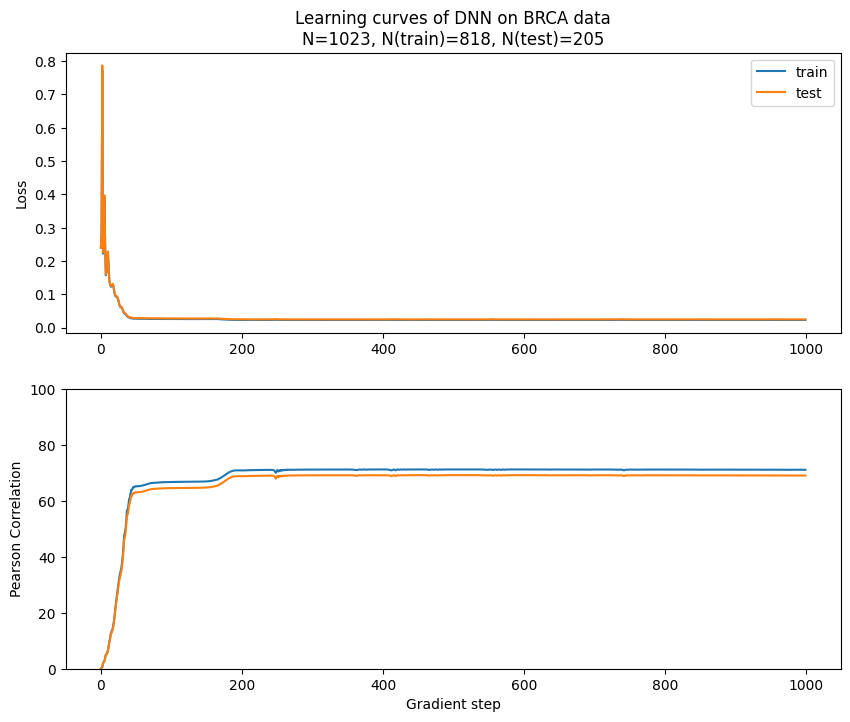

In [86]:
plot_learning_curves(trl, tstl, trc, tstc, tpm_data, X_train, X_test)

In [87]:
def plot_ae_performance(mm, X_test, modeltype = "AE", dataset = "TPM_DATA"):
    y_tst_out = mm(X_test)
    outs = y_tst_out.flatten().detach().numpy()
    trues = X_test.flatten().detach().numpy()
    corr =  pearsonr(outs,trues).statistic
    plt.figure(figsize = (9,7))
    plt.grid(visible =True, alpha = 0.5, linestyle = "--")
    lims = max([max(outs), max(trues)])
    plt.plot([0,lims],[0,lims], color = "blue", alpha =0.5, linestyle = "--")
    plt.hexbin(outs, trues, bins = "log")
    plt.xlabel("Predicted Expressions (normalised TPM)")
    plt.ylabel("True expressions")
    plt.colorbar(label='log10(N)')
    plt.axis("equal")
    plt.title(f"Auto-Encoder performance of reconstruction on test set with {datasetname} data.\nPearson Correlation: {round(corr,4)}")
    plt.savefig(f"figures/{modeltype}_{dataset}_reconstruction.png", format="png", dpi=500)

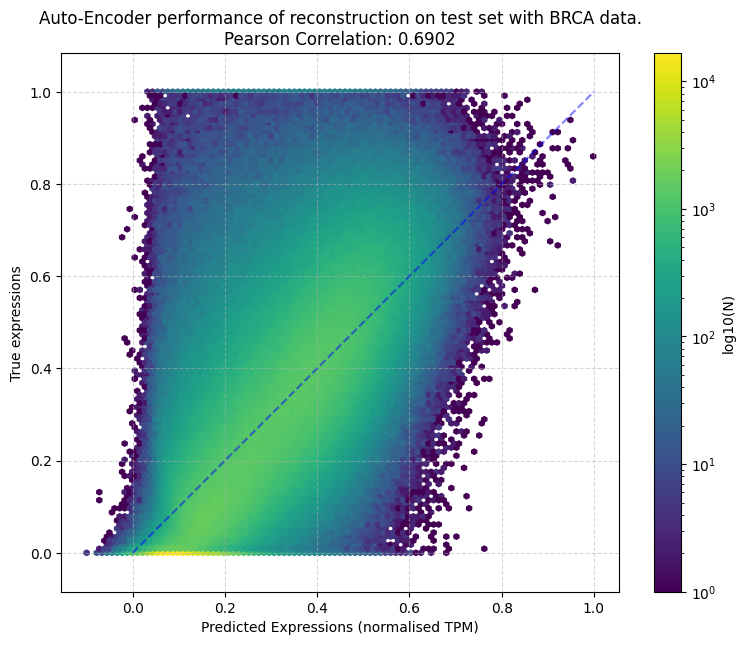

In [88]:
plot_ae_performance(VAE, X_test, modeltype ="VAE", dataset = datasetname)

## IV. UMAP supervise

In [89]:
lblenc = LabelEncoder()
lblenc.fit(labels)
Y = lblenc.transform(labels)
X_train, X_test, Y_train, Y_test = train_test_split(tpm_data.T, Y, test_size = 0.2)
mapper = umap.UMAP(verbose = 1, n_components = 2, min_dist=1., 
    n_neighbors =5, n_epochs = 1000).fit(X_train,  y = Y_train)

UMAP(min_dist=1.0, n_epochs=1000, n_neighbors=5, verbose=1)
Sun Dec 17 13:08:09 2023 Construct fuzzy simplicial set
Sun Dec 17 13:08:11 2023 Finding Nearest Neighbors
Sun Dec 17 13:08:11 2023 Finished Nearest Neighbor Search
Sun Dec 17 13:08:11 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Sun Dec 17 13:08:14 2023 Finished embedding


In [90]:
X_tr_umap = mapper.transform(X_train)
X_tst_umap = mapper.transform(X_test)

Epochs completed:   0%|            0/333 [00:00]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs


In [91]:
def plot_umap(X_train_umap, X_test_umap, Y_train, Y_test, labels, s= 8):
    fig, ax1 = plt.subplots(figsize=(9,7))
    ax1.grid(visible=True,linestyle="--")
    ax1.set_axisbelow(True)
    markers_ = np.concatenate([['o',"v","^","<",">","8","p","s","h","D","P","X"] for i in range(10)])
    colors_by_ctype = [random_color_generator() for  i in range(len(np.unique(labels)))]
    for (i,lbl) in enumerate(np.unique(labels)):
        #defin_ = tcga_abbrevs.loc[tcga_abbrevs["abbrv"] == lbl,"def"].values[0] 
        #count_ = counts_df.loc[counts_df["c_type"] == lbl,"count"].values[0]
        #tag = f"{defin_} ({count_})"
        #print(X_tr_tsne[labels ==lbl,0])
        ax1.scatter(X_train_umap[Y_train ==lbl,0], 
                X_train_umap[Y_train ==lbl,1], 
                s = s, color = colors_by_ctype[i], linewidth = 0.5, marker=markers_[i], label = lbl)
        ax1.scatter(X_test_umap[Y_test ==lbl,0], 
                X_test_umap[Y_test ==lbl,1], 
                s = s, edgecolors = colors_by_ctype[i], color ="white", linewidth = 0.5, marker=markers_[i])

    ax1.axis("equal")
    ax1.legend(bbox_to_anchor=(1,1),fontsize = 8, title="Type of cancer")
    ax1.set_xlabel("UMAP1")
    ax1.set_ylabel("UMAP2")
    #fig.tight_layout()
    plt.title(f"Supervised UMAP analysis of gene expression with the test points for {datasetname} data")
    plt.tight_layout()
    plt.savefig(f"figures/figUMAP_supervise_{datasetname}.png", format="png", dpi=500)

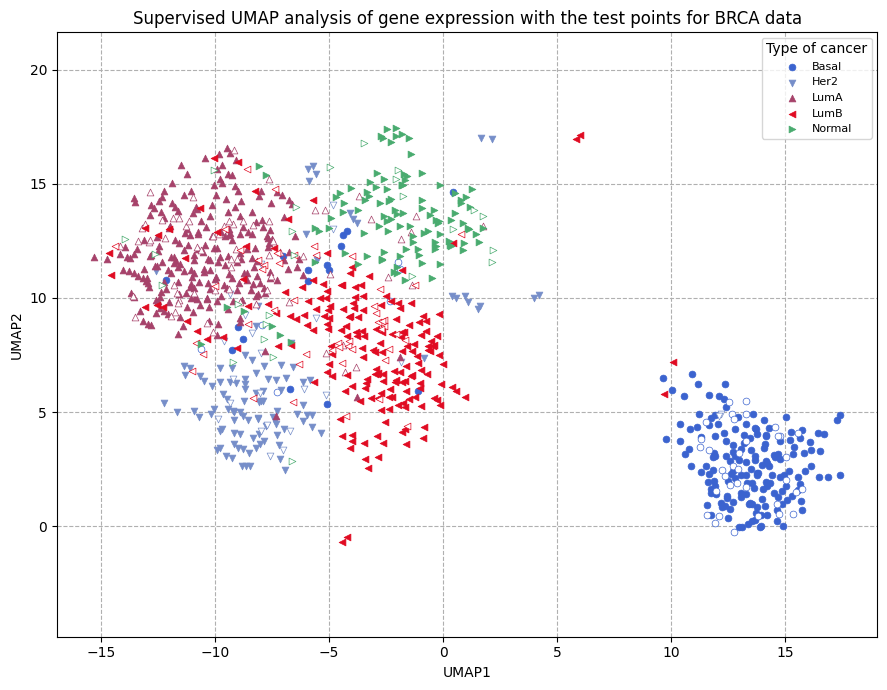

In [93]:
plot_umap(X_tr_umap, X_tst_umap, lblenc.inverse_transform(Y_train), lblenc.inverse_transform(Y_test), labels, s = 24)